In [1]:
!pip install --q accelerate diffusers datasets ftfy regex
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-io38yhz_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-io38yhz_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=3c7b5d7dca0480b0c2e218f8dd9299a28f8d975023bf5d4461e07ff57995e28f
  Stored in directory: /tmp/pip-ephem-wheel-cache-k98cfzmz/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Gen txt

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import random
import numpy as np
import torch

In [3]:
# Load model
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU")
else:
    device = "cpu"
    print("Using CPU")

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
superprompt_model = T5ForConditionalGeneration.from_pretrained("roborovski/superprompt-v1", device_map="auto")

superprompt_model.to(device)
print(f"Downloaded & Loaded SuperPrompt-v1 on {'GPU' if device == 'cuda' else 'CPU'}")

Using GPU


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Downloaded & Loaded SuperPrompt-v1 on GPU


In [4]:
# Load dataset
from datasets import load_dataset

prompts = load_dataset("shunk031/DrawBench", split="test")
# prompts = prompts.shuffle()
sample_prompts = [prompt["prompts"] for prompt in prompts]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

In [5]:
prompts = load_dataset("sayakpaul/drawbench-upsampled-zephyr-7b-alpha", split="train")
# prompts = prompts.shuffle()
upsampled_prompts = [prompt["Upsampled Prompt"] for prompt in prompts]

Generating train split:   0%|          | 0/200 [00:00<?, ? examples/s]

In [6]:
from tqdm import tqdm
# Superprompt prompt
system_prompt = "Expand the following prompt to add more detail: "
superprompt_prompts = [system_prompt + prompt for prompt in sample_prompts]
for i in tqdm(range(len(superprompt_prompts))):
  input_text = superprompt_prompts[i]
  input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
  outputs = superprompt_model.generate(input_ids, max_new_tokens=77)
  superprompt_prompts[i] = tokenizer.decode(outputs[0], skip_special_tokens=True).replace("", "").replace("", "")

  0%|          | 0/200 [00:00<?, ?it/s]2024-04-16 15:21:44.211964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 15:21:44.212062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 15:21:44.354389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 200/200 [03:23<00:00,  1.02s/it]


In [7]:
del superprompt_model

In [ ]:
for i in range(5):
    print(sample_prompts[i])
    print(upsampled_prompts[i])
    print(superprompt_prompts[i])
    print()

# Gen img

In [ ]:
from diffusers import DiffusionPipeline

ckpt_id = "runwayml/stable-diffusion-v1-5"
pipe = DiffusionPipeline.from_pretrained(ckpt_id, torch_dtype=torch.float16).to("cuda")

In [8]:
sample_images = []
superprompt_images = []
upsample_images = []

In [ ]:
from diffusers import DPMSolverMultistepScheduler

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# disables safety checks
def disabled_safety_checker(images, clip_input):
    if len(images.shape)==4:
        num_images = images.shape[0]
        return images, [False]*num_images
    else:
        return images, False
pipe.safety_checker = disabled_safety_checker

In [ ]:
from PIL import Image

BATCH_SIZE = 4

def gen_and_save_im(i: int, prompts=[], im_list=[], tp=''):
  images = pipe(prompts, num_inference_steps=20, output_type="np").images
  im_list.append(images)
  for j in range(len(images)):
      im = Image.fromarray((images[j]*255).astype(np.uint8))
      img_name = "img_1/sdxl_" + tp + f"_{i + j}.png"
      im.save(img_name)
  return im_list

for i in tqdm(range(0, len(sample_prompts), BATCH_SIZE)):
  samples = sample_prompts[i : i + BATCH_SIZE]
  superprompts = superprompt_prompts[i : i + BATCH_SIZE]
  upsampledprompts = upsampled_prompts[i : i + BATCH_SIZE]

  # Regular captions.
  gen_and_save_im(i, samples, sample_images, "org")

  # Superprompt captions.
  gen_and_save_im(i, superprompts, superprompt_images, "superprompt")

  # Upsampled captions.
  gen_and_save_im(i, upsampledprompts, upsample_images, "upsampled")

# Evaluation

In [9]:
import cv2
import os
from PIL import Image


file_list = sorted(os.listdir('/kaggle/input/superpromt-img-test/img_1/'), key=lambda x: int(x[x.rfind("_")+1: x.rfind(".")]))

# Load in the images
for filepath in file_list:
    if "org" in filepath:
        sample_images.append(Image.open('/kaggle/input/superpromt-img-test/img_1/{0}'.format(filepath)))
    elif "superprompt" in filepath:
        superprompt_images.append(Image.open('/kaggle/input/superpromt-img-test/img_1/{0}'.format(filepath)))
    else:
        upsample_images.append(Image.open('/kaggle/input/superpromt-img-test/img_1/{0}'.format(filepath)))

In [14]:
import statistics

def calculate_CLIP_score(model, preprocess, img_list=[], txt_list=[], device=device):
    scores = []
    for i in range(len(img_list)):
        image = preprocess(img_list[i]).unsqueeze(0).to(device)
        text = clip.tokenize(txt_list[i], context_length=77, truncate=True).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            scores.append(torch.cosine_similarity(image_features, text_features).item())
    return round(float(100*statistics.mean(scores)), 4)

NameError: name 'device' is not defined

In [53]:
import statistics

def calculate_im_gen_diversity(model, preprocess, img_list=[], device=device):
    im_embs = []
    for i in range(len(img_list)):
        image = preprocess(img_list[i]).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            im_embs.append(image_features)
    combined_tensor = torch.cat([im_emb.squeeze(0) for im_emb in im_embs], dim=0)
    mean = combined_tensor.mean(dim=0, keepdim=True)
    squared_diffs = (combined_tensor - mean)**2
    variance = squared_diffs.mean(dim=0, keepdim=True)
    return variance

In [13]:
from io import BytesIO
import numpy as np
import statistics

def calculate_img_musiq(predict_fn, img_list=[]):
    scores = []
    for image in tqdm(img_list):
        image_bytes = BytesIO()
        image.save(image_bytes, format='PNG')
        image_bytes = image_bytes.getvalue()
        prediction = predict_fn(tf.constant(image_bytes))
        scores.append(float(np.array(prediction['output_0'])))
    return round(float(statistics.mean(scores)), 4)

In [11]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
#CLIP ViT-L/14, ViT-B/32
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 155MiB/s]


In [ ]:
calculate_CLIP_score(model, preprocess, sample_images, sample_prompts, device)

In [ ]:
calculate_CLIP_score(model, preprocess, superprompt_images, superprompt_prompts, device)

In [ ]:
calculate_CLIP_score(model, preprocess, upsample_images, upsampled_prompts, device)

In [54]:
calculate_im_gen_diversity(model, preprocess, sample_images, device)

tensor([0.2260], device='cuda:0', dtype=torch.float16)

In [55]:
calculate_im_gen_diversity(model, preprocess, superprompt_images, device)

tensor([0.2275], device='cuda:0', dtype=torch.float16)

In [56]:
calculate_im_gen_diversity(model, preprocess, upsample_images, device)

tensor([0.2283], device='cuda:0', dtype=torch.float16)

In [ ]:
!pip install jax==0.4.16 jaxlib==0.4.16

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('/kaggle/input/musiq/tensorflow2/ava/1')
predict_fn = model.signatures['serving_default']

2024-04-16 10:50:47.144888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 10:50:47.144947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 10:50:47.146422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
calculate_img_musiq(predict_fn, sample_images)

100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


5.2037

In [30]:
calculate_img_musiq(predict_fn, superprompt_images)

100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


5.4708

In [31]:
calculate_img_musiq(predict_fn, upsample_images)

100%|██████████| 200/200 [00:36<00:00,  5.48it/s]


5.4852

In [60]:
random.sample(range(0, len(sample_prompts) + 1), 5)

[175, 181, 171, 164, 110]

In [67]:
print(sample_prompts[175])
print(upsampled_prompts[175])
print(superprompt_prompts[175])

A 1960s poster warning against climate change.
In the midst of the Vietnam War, a poster warns against an impending crisis that threatens to consume the planet. "THE EARTH IS CRYING OUT FOR HELP" reads the bold headline in red, with images of melting glaciers, smoke-filled skies, and barren fields. The poster was created in 1968, before climate change became a mainstream issue, and served as a call to action for a generation of activists who sought to protect the environment for future generations.
In bold, white letters against a deep red background, the words "Case Change" are written in a bold, black font. The words are surrounded by a hazy, ethereal message that echoes through the city. The poster is framed by a small, white border, indicating the importance of climate change in


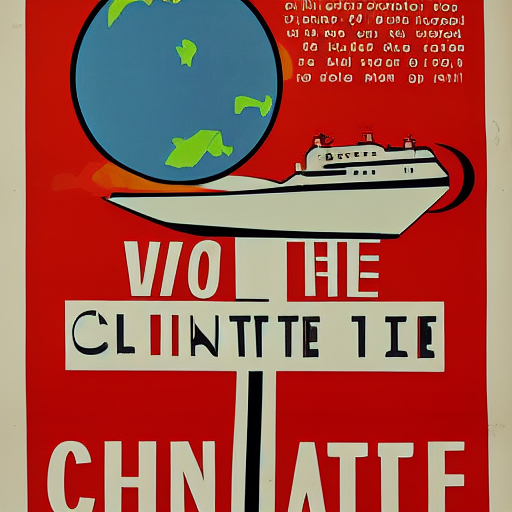

In [68]:
sample_images[175]